In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import scipy.stats

from qbitmap import simulated_annealer
from qbitmap import utils
from qbitmap import io

### State space analysis

Here we analyze some metrics that we would otherwise like to observe in hardware to demonstrate good potential for SA.

#### Comparison of $F$, $F_{LE}$, $F_0$


In [3]:
n_qubits = 5
tag = "contrived"
path_fname, res_fname = io.make_experiment_fout(
    connectivity="line", 
    circuit_name="ghz", 
    n_qubits=n_qubits, 
    tag=tag, 
    path="./results")

all_paths = np.load(path_fname)
results = np.load(res_fname)

rand_path_fname, rand_fname = io.make_experiment_fout(
    connectivity="line", 
    circuit_name="ghz", 
    n_qubits=n_qubits, 
    tag=tag, 
    path="./results")

rand_all_paths = np.load(rand_path_fname)
assert np.allclose(rand_all_paths, all_paths)
results_rand = np.load(rand_fname)

In [4]:
F = results[:,0].flatten()
FLE = results[:,1].flatten()
F0 = results[:,2].flatten()
reorder_idx = np.argsort(F)


correction = .5 * (FLE / F0**2 - 1)
prediction = F0 * (1 + correction)


#### Compute correlation coefficients

In [5]:
FLE = results[:,1].flatten()
F0 = results[:,2].flatten()
F = results[:,0].flatten()

print("FLE:", scipy.stats.kendalltau(FLE, F))
print("F0", scipy.stats.kendalltau(F0, F))

FLE: KendalltauResult(correlation=0.9952864678816444, pvalue=0.0)
F0 KendalltauResult(correlation=0.9344754284954911, pvalue=0.0)


#### Locality of the cost function


In [6]:
# new analysis
G = nx.Graph()

for i, path_i in enumerate(all_paths):
    if (i % 100) == 0:
        print(i)
    F_LE_i, F_i, F0_i = results[i]
    G.add_node(i, F_LE=F_LE_i, F=F_i)
    q_i =  set(tuple(map(tuple, path_i)))

    # Track the edges used, agnostic to ordering
    edges_i = [(tuple(path_i[k]), tuple(path_i[k+1])) for k in range(n_qubits - 1)]
    
    edges_i += [(t[1], t[0]) for t in edges_i]
    for j, path_j in enumerate(all_paths):
        if j <= i:
            continue
        q_j =  set(tuple(map(tuple, path_j)))
        edges_j = [(tuple(path_j[k]), tuple(path_j[k+1])) for k in range(n_qubits - 1)]
        edges_j += [(t[1], t[0]) for t in edges_j]
        
        # Number of shared qubits
        w_ij = len(q_i.intersection(q_j))
        # Number of shared edges
        ee_ij = len(set(edges_i).intersection(set(edges_j))) // 2
        
        G.add_edge(i, j, shared_edges=ee_ij, shared_nodes=w_ij)

0
100
200
300
400
500
600
700
800
900


In [8]:
FLE_by_weight = {} # weight=0, 1, 2, 3, 4 - 4 since i did actually run forwards and  backwards variations...
F_by_weight = {}
for (i, j, data) in G.edges(data=True):
    delta_FLE = G.nodes[i]['F_LE'] - G.nodes[j]['F_LE']   
    delta_F = G.nodes[i]['F'] - G.nodes[j]['F']
    (ns, es) = (data['shared_nodes'], data['shared_edges'])
    if not FLE_by_weight.get((ns, es)):
        FLE_by_weight[(ns, es)] = []
    if not F_by_weight.get((ns, es)):
        F_by_weight[(ns, es)] = []   
        
    FLE_by_weight[(ns, es)].append(delta_FLE)
    F_by_weight[(ns, es)].append(delta_F)

    
FLE_by_weight = {k: np.asarray(x) for (k, x) in FLE_by_weight.items()}
F_by_weight = {k: np.asarray(x) for (k, x) in F_by_weight.items()}

### Plot Figure 2

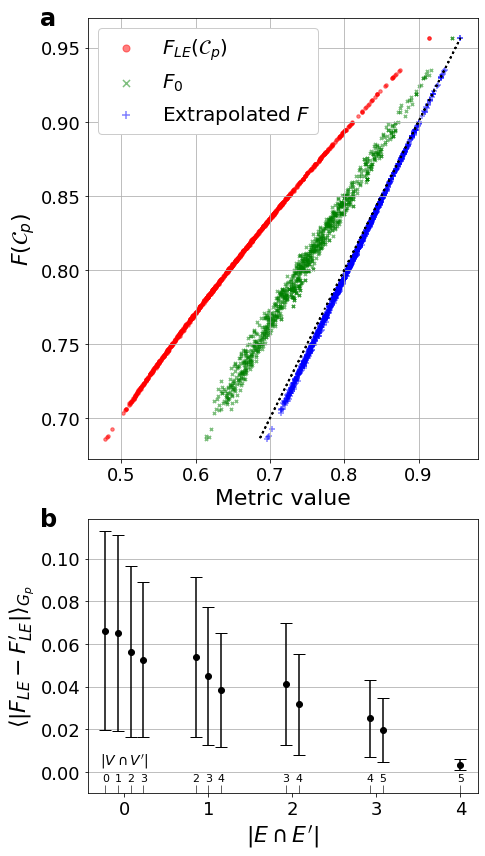

In [10]:
# fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True, constrained_layout=True)

axlabsize = 22
xticklabsize = 18
leglabsize = 20
fig = plt.figure(figsize=(7, 12))
gs = fig.add_gridspec(5, 1)

ax = fig.add_subplot(gs[0:3])
ax.set_ylabel(r"$F(\mathcal{C}_p)$", size=axlabsize)
ax.set_xlabel("Metric value", size=axlabsize)
ax.tick_params(axis='both', which='major', labelsize=xticklabsize)

s = 10
ax.scatter(FLE, F, marker='o', c='r', alpha=0.5, s=s*1.2, label=r"$F_{LE}(\mathcal{C}_p)$")
ax.scatter(F0, F, marker='x', c='g', alpha=0.5, s=s, label=r"$F_0$")
ax.scatter(prediction, F, marker='+', c='b', alpha=0.5, label=r"Extrapolated $F$")
ax.plot(F, F,  c='k', lw=2, ls=':')

leg = ax.legend(prop={"size": leglabsize}, loc="upper left", framealpha=1)
#change the marker size manually for both lines
for handle in leg.legendHandles:
    handle._sizes = [50]

ax.grid(True)

# State space similarity
ax2 = fig.add_subplot(gs[3:])

# this list has length n_qubits with each index corresponding to a number
# of shared edges
FLE_vertices_by_edge = [[] for _ in range(n_qubits)]

for (ns, es) in FLE_by_weight.keys():    
    dFLE = FLE_by_weight.get((ns, es))
    FLE_vertices_by_edge[es].append((ns, np.mean(abs(dFLE)), utils.std_absX(dFLE)))
    
minor_ticks = []
minor_xticklabels = []
for es, ns_vals in enumerate(FLE_vertices_by_edge):
    pt_idx = np.arange(len(ns_vals))
    x = es
    dx = 0.15
    width = (len(pt_idx) - 1) * dx
    subspacings = x + pt_idx * dx - width/2 + .0001 # tiny epsilon so we can overlay on edge markers
    
    # Unpack the values and sort by increasing number of shared qubits
    ns, xvals, yvals = zip(*ns_vals)
    idx = np.argsort(ns)
    ns = np.array(ns)[idx]
    xvals = np.array(xvals)[idx]
    yvals = np.array(yvals)[idx]
    ax2.errorbar(subspacings, xvals, yerr=yvals, markersize=6, marker='o', fmt='.', capsize=6, c='k')

    # Track every point plotted as these will become the xlabel indicators
    minor_ticks += list(subspacings)
    minor_xticklabels += list(ns)

# cAPTION
ax.text(-0.1, 1, r"a", horizontalalignment='center', verticalalignment='center', size=24, transform=ax.transAxes, weight="bold")

# Compute the offset of nested dots based on how many there are to plot
# minor_ticks = [es - 0.2 + 0.1 * ns for (ns, es) in FLE_by_weight.keys()]
ticklabs = [ns for (ns, es) in FLE_by_weight.keys()]

ax2.set_ylabel(r"$\langle |F_{LE} - F_{LE}'| \rangle_{G_p}$", size=axlabsize)
ax2.set_xlabel(r"$|E \cap E'|$", size=axlabsize)

ax2.set_xticks(range(0, 5))
ax2.set_ylim(-0.01, ax2.get_ylim()[1])
ax2.set_xticklabels(range(5))
ax2.set_xticks( minor_ticks, minor=True )
ax2.set_xticklabels(minor_xticklabels, minor=True, size=11)
ax2.tick_params( axis='x', which='minor', direction='in', length=8, pad=-20 )
ax2.tick_params(axis='both', which='major', labelsize=xticklabsize)

ax2.text(0, 0.005, r"$|V \cap V'|$", horizontalalignment='center', verticalalignment='center', size=14)
ax2.grid(True, axis='y')
plt.tight_layout()

# cAPTION
ax2.text(-0.1, 1, r"b", horizontalalignment='center', verticalalignment='center', size=24, transform=ax2.transAxes, weight="bold")


# DRAFT
import os
DRAFT = False

if DRAFT:
    ax.text(0, 1.05, os.getcwd()+"/line_connectivity_state_space_analysis_v1.ipynb", color='red', horizontalalignment='left', verticalalignment='center', size=12, transform=ax.transAxes, weight="bold")

    
fig.savefig("../../figures/figure2.pdf",bbox_inches='tight')